<a href="https://www.kaggle.com/code/erwanchesneau/notebook-exploration?scriptVersionId=104536913" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Python librairies

In [3]:
import pandas as pd
import cudf
import matplotlib.pyplot as plt

# Variables

In [4]:
TRAIN_PATH = '../input/amex-data-integer-dtypes-parquet-format/train.parquet'
TEST_PATH = '../input/amex-data-integer-dtypes-parquet-format/test.parquet'

# functions

In [5]:
def read_dataset(path, fmt='csv', fillnan=None) :
    """
    Function to read dataset in different formats, with an option to fill NaN values
        
    cat_feat = ["B_30","B_38","D_114","D_116","D_117","D_120",\
                    "D_126","D_63","D_64","D_66","D_68"]
    obj_features = ['D_63', 'D_64']
    """
    if fmt == 'csv' :
        data = cudf.read_csv(path)
    elif fmt == 'feather' :
        data = cudf.read_feather(path)
    elif fmt == 'parquet' :
        data = cudf.read_parquet(path)
    else :
        print(f"Unknown format {fmt}")
        return None
    data['customer_ID'] = data['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    if 'S_2' in data.columns :
        data.S_2 = cudf.to_datetime( data.S_2 )
    if 'target' in data.columns and len(data.columns)>2:
        data.drop('target', axis=1, inplace=True)
    if fillnan is not None :
        data = data.fillna(fillnan)
    return data.set_index('customer_ID')

# Load dataset

## Labels

In [6]:
train_labels = read_dataset('../input/amex-default-prediction/train_labels.csv', fmt='csv')
train_labels.head()

,target
customer_ID,
-4532153018459703766,0
-6696652885210834715,0
7128959966677571777,0
6537921148391624412,0
2065103583825424365,0


Numbers of customers : 458913
Numbers of duplicates : 0
Numbers of NaN : 0


<AxesSubplot:ylabel='target'>

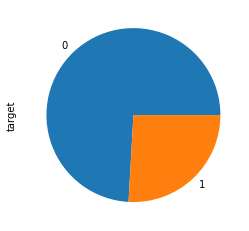

In [7]:
print(f"Numbers of customers : {len(train_labels)}")
print(f"Numbers of duplicates : {train_labels.to_pandas().index.duplicated().sum()}")
print(f"Numbers of NaN : {train_labels.isna().any().sum()}")
train_labels.to_pandas().target.value_counts().plot.pie()

Train label database does not contained duplicated neither NaN value

In [8]:
train_labels.head()

,target
customer_ID,
-4532153018459703766,0
-6696652885210834715,0
7128959966677571777,0
6537921148391624412,0
2065103583825424365,0


## Data
The dataset of this competition has a considerable size.
If you read the original csv files, the data barely fits into memory.
That's why we read the data from @RADAR's AMEX data - integer dtypes - parquet format dataset.
In this Feather file, the floating point precision has been reduced from 64 bit to 16 bit.
And reading a parquet file is faster than reading a csv file because the parquet file
format is binary.

In [9]:
train = read_dataset(TRAIN_PATH, fmt='parquet').to_pandas()
test = read_dataset(TEST_PATH, fmt='parquet')
with pd.option_context("display.min_rows", 6):
    display(train)

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
-4532153018459703766,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
-4532153018459703766,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
-4532153018459703766,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-8425848485496994175,2018-01-06,0.983019,15,0.013151,0.815422,0.003457,0.100503,0.0,0.012343,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.006773,0
-8425848485496994175,2018-02-06,0.969861,15,0.009855,1.003541,0.005117,0.101802,0.0,0.008578,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.001168,0
-8425848485496994175,2018-03-14,0.982175,0,0.000077,0.992880,0.000809,0.119165,0.0,0.014092,NaN,...,-1,-1,-1,0,0,0.0,NaN,0,0.003184,0


Label and  the train database are merge

In [11]:
train = train.merge(train_labels.to_pandas(), left_index=True, right_index=True, how='left')
del train_labels

In [12]:
train = train.reset_index()
test = test.reset_index()

In [13]:
count = train.customer_ID.value_counts()
print(f"Numbers of rows : {len(train)}")
print(f"Numbers of duplicates : {len(count[count>1])}")
print(f"Numbers of variables : {len(train.columns)}")
print(f"Numbers of NaN : {train.isna().any().sum()}")

Numbers of rows : 5531451
Numbers of duplicates : 453793
Numbers of variables : 191
Numbers of NaN : 67


 This dataset contains 190 variables. Features are anonymized and normalized,
 and fall into the following general categories:
 
D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables

Many IDs are duplicated since each operation is reported.
The variable S_2 is the date of each operations

# Exploration Data Analysis
An interesting EDA was performed by @AMBROSM.
This part is inspired by his notebook.

## NaN values

<AxesSubplot:>

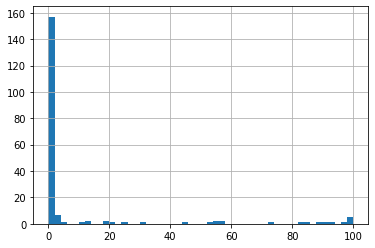

In [14]:
counter = train.isnull().sum(axis=0).sort_values(ascending=False)/len(train)*100
counter.hist(bins=50)

Some features are majoritary not filled,
the completion will not be efficient
so we decide to remove features with more 50% NaN values.

In [15]:
rm_feat = counter[counter>50].index.tolist()
rm_feat

['D_88',
 'D_110',
 'B_39',
 'D_73',
 'B_42',
 'D_134',
 'B_29',
 'D_132',
 'D_76',
 'D_42',
 'D_142',
 'D_53',
 'D_50',
 'B_17',
 'D_105',
 'D_56',
 'S_9']

## Counting the statements per customer

Now we can count how many rows (credit card statements) there are per customer.
We see that 80 % of the customers have 13 statements;
the other 20 % of the customers have between 1 and 12 statements.
​  
**Insight:** Our model will have to deal with a variable-sized input per customer
(unless we simplify our life and look only at the most recent statement as @inversion suggests
[here](https://www.kaggle.com/competitions/amex-default-prediction/discussion/327094)
or at the average over all statements).

In [16]:
train

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,-9223358381327749917,2017-03-31,0.342033,9,0.298571,0.028331,0.506896,0.793958,0.000000,0.823765,...,-1,-1,0,0,0.0,NaN,0,0.004787,0,1
1,-9223358381327749917,2017-04-07,0.340178,16,0.353684,0.026975,0.505335,0.795727,0.000000,0.825231,...,-1,-1,0,0,0.0,NaN,0,0.003442,0,1
2,-9223358381327749917,2017-05-23,0.356010,1,0.448582,0.026601,0.506290,0.530133,0.000000,0.923707,...,-1,-1,0,0,0.0,NaN,0,0.003340,0,1
3,-9223358381327749917,2017-06-22,0.378665,1,0.443752,0.024322,0.509069,0.539285,0.000000,0.915724,...,-1,-1,0,0,0.0,NaN,0,0.007556,0,1
4,-9223358381327749917,2017-07-22,0.416543,1,0.463824,0.023064,0.505335,0.461935,0.000000,0.919373,...,-1,-1,0,0,0.0,NaN,0,0.005299,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,9223350112805974911,2017-11-30,0.305949,10,0.991321,0.046696,0.504790,0.101036,0.580891,0.727668,...,-1,-1,0,0,0.0,NaN,0,0.003152,0,1
5531447,9223350112805974911,2017-12-02,0.300828,12,0.997546,0.041142,0.509450,0.112134,0.588240,0.733828,...,-1,-1,0,0,0.0,NaN,0,0.002049,0,1
5531448,9223350112805974911,2018-01-22,0.275922,1,1.063711,0.048840,0.006889,0.154854,0.605807,0.714096,...,-1,-1,0,0,0.0,NaN,0,0.000250,0,1
5531449,9223350112805974911,2018-02-20,0.281470,2,0.969155,0.023165,0.004202,0.176485,0.514922,0.871177,...,-1,-1,0,0,0.0,NaN,0,0.007640,0,1


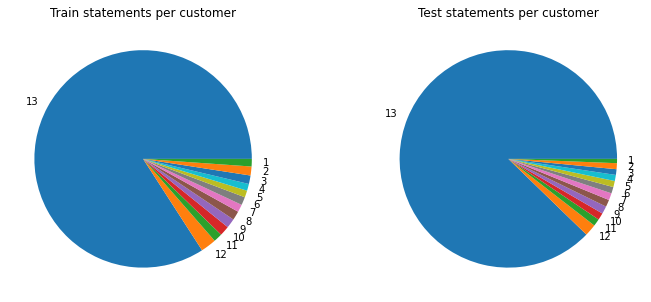

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
train_sc = train.customer_ID.value_counts().value_counts()
train_sc = train_sc.sort_index(ascending=False).rename('Train statements per customer')
ax1.pie(train_sc, labels=train_sc.index)
ax1.set_title(train_sc.name)
test_sc = test.customer_ID.value_counts().value_counts()
test_sc = test_sc.sort_index(ascending=False).rename('Test statements per customer')
test_sc.index.to_pandas()
ax2.pie(test_sc.to_array(), labels=test_sc.index.to_pandas())
ax2.set_title(test_sc.name)
plt.show()


Let's find out when these customers got their last statement.
The histogram of the last statement dates shows that every train
customer got his last statement in March of 2018. The first four
Saturdays (March 3, 10, 17, 24) have more statements than an average day.

The test customers are split in two: half of them got their last statement in April of 2019
and half in October of 2019. As was [discussed here]
(https://www.kaggle.com/competitions/amex-default-prediction/discussion/327602),
the April 2019 data is used for the public leaderboard and the October 2019 data is used
for the private leaderboard.

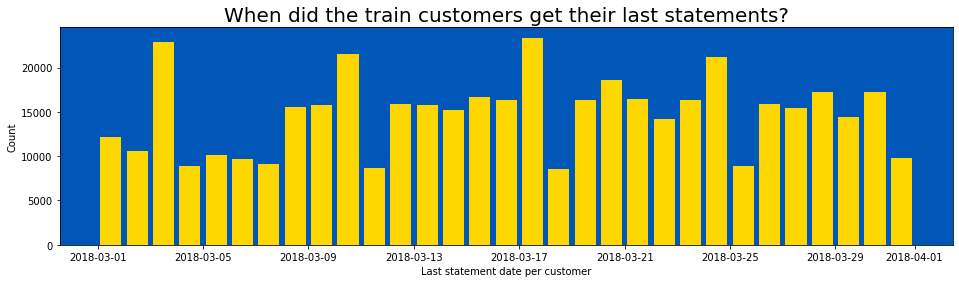

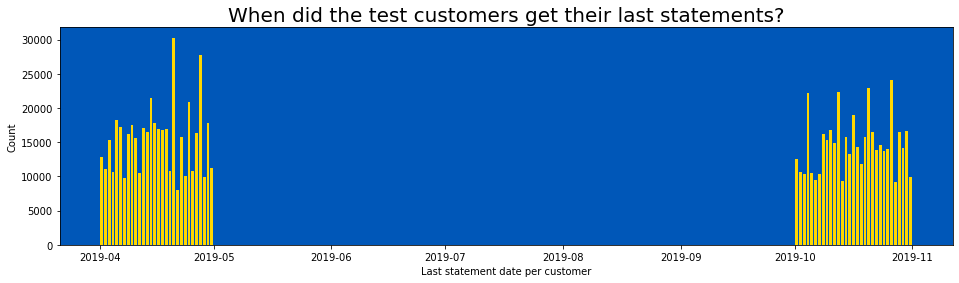

In [37]:
temp = train.S_2.groupby(train.customer_ID).max()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range("2018-03-01", "2018-04-01", freq="d"),
         rwidth=0.8, color='#ffd700')
plt.title('When did the train customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

temp = test.S_2.groupby(test.customer_ID).max().to_pandas()
plt.figure(figsize=(16, 4))
plt.hist(temp, bins=pd.date_range("2019-04-01", "2019-11-01", freq="d"),
         rwidth=0.74, color='#ffd700')
plt.title('When did the test customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

**Insight:** Although the data are a kind of time series,
we cannot cross-validate with a TimeSeriesSplit because all training happens in the same month.

For most customers, the first and last statement is about a year apart.
Together with the fact that we typically have 13 statements per customer,
this indicates that the customers get one credit card statement every month.

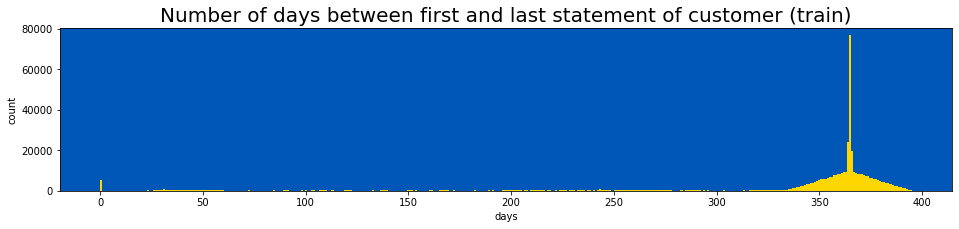

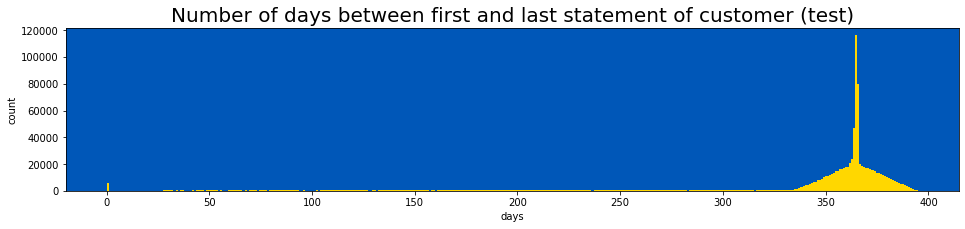

In [38]:
temp = train.S_2.groupby(train.customer_ID).agg(['max', 'min'])
plt.figure(figsize=(16, 3))
plt.hist((temp['max'] - temp['min']).dt.days, bins=400, color='#ffd700')
plt.xlabel('days')
plt.ylabel('count')
plt.title('Number of days between first and last statement of customer (train)', fontsize=20)
plt.gca().set_facecolor('#0057b8')
plt.show()

temp = test.S_2.groupby(test.customer_ID).agg(['max', 'min']).to_pandas()
plt.figure(figsize=(16, 3))
plt.hist((temp['max'] - temp['min']).dt.days, bins=400, color='#ffd700')
plt.xlabel('days')
plt.ylabel('count')
plt.title('Number of days between first and last statement of customer (test)', fontsize=20)
plt.gca().set_facecolor('#0057b8')
plt.show()
del temp

If we color every statement (i.e. row of train or test) according to the dataset it belongs
(training, public lb, and private lb), we see that every dataset covers thirteen months.
Train and test don't overlap, but public and private lb periods overlap.

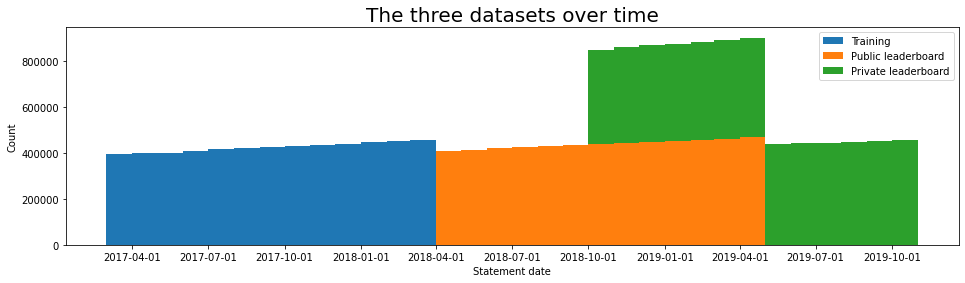

In [43]:
temp = pd.concat([train[['customer_ID', 'S_2']], test[['customer_ID', 'S_2']].to_pandas()], axis=0)
temp.set_index('customer_ID', inplace=True)
temp['last_month'] = temp.groupby('customer_ID').S_2.max().dt.month
last_month = temp['last_month'].values

plt.figure(figsize=(16, 4))
plt.hist([temp.S_2[temp.last_month == 3],   # ending 03/18 -> training
          temp.S_2[temp.last_month == 4],   # ending 04/19 -> public lb
          temp.S_2[temp.last_month == 10]], # ending 10/19 -> private lb
         bins=pd.date_range("2017-03-01", "2019-11-01", freq="MS"),
         label=['Training', 'Public leaderboard', 'Private leaderboard'],
         stacked=True)
plt.xticks(pd.date_range("2017-03-01", "2019-11-01", freq="QS"))
plt.xlabel('Statement date')
plt.ylabel('Count')
plt.title('The three datasets over time', fontsize=20)
plt.legend()
plt.show()


Now we'll look at the distribution of missing values over time.
B_29 is most interesting. Given the each of the three datasets has almost half a million
customers, we see that until May of 2019 fewer than a tenth of the customers
have a value for B_29. The other nine tenths are missing. Starting in June of 2019,
we have B_29 data for almost every customer.

**Insight:** The distribution of the missing B_29 differs between train and test datasets.
Whereas in the training and public leaderboard data >90 % are missing,
during the last five months of private leaderboard, we have B_29 data for almost every customer.
If we use this feature, we should be prepared for surprises in the private leaderboard.
Is it better to drop the feature?

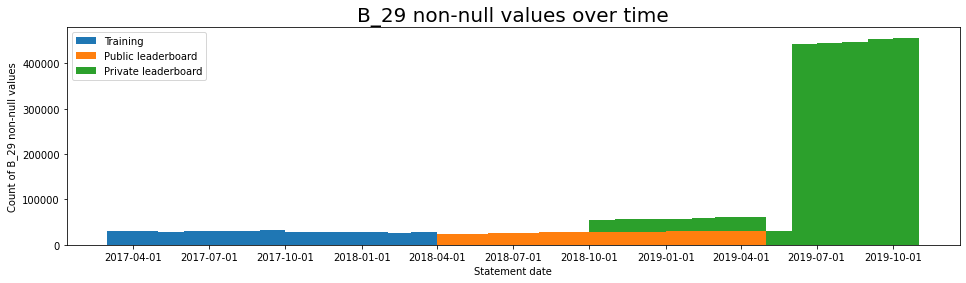

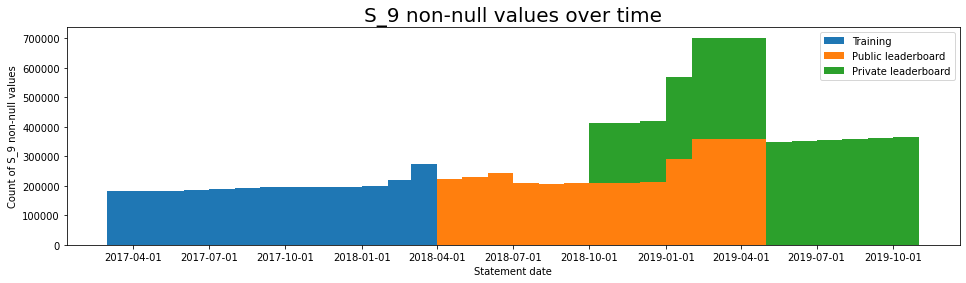

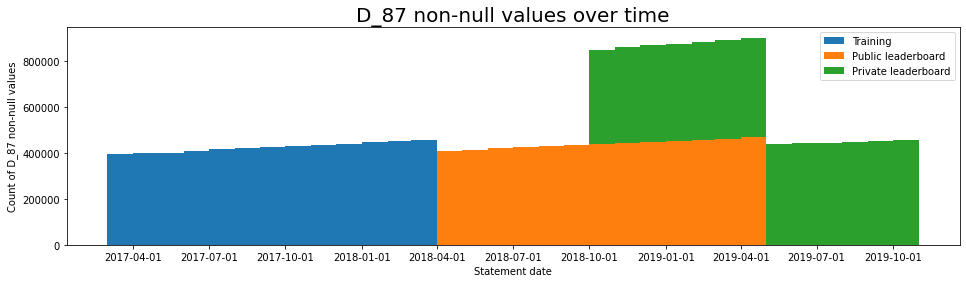

In [44]:
for f in [ 'B_29', 'S_9','D_87']:
    #, 'D_88', 'R_26', 'R_27', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42']:
    temp = pd.concat([train[[f, 'S_2']], test[[f, 'S_2']].to_pandas()], axis=0)
    temp['last_month'] = last_month
    temp['has_f'] = ~temp[f].isna()

    plt.figure(figsize=(16, 4))
    plt.hist([temp.S_2[temp.has_f & (temp.last_month == 3)],   # ending 03/18 -> training
              temp.S_2[temp.has_f & (temp.last_month == 4)],   # ending 04/19 -> public lb
              temp.S_2[temp.has_f & (temp.last_month == 10)]], # ending 10/19 -> private lb
             bins=pd.date_range("2017-03-01", "2019-11-01", freq="MS"),
             label=['Training', 'Public leaderboard', 'Private leaderboard'],
             stacked=True)
    plt.xticks(pd.date_range("2017-03-01", "2019-11-01", freq="QS"))
    plt.xlabel('Statement date')
    plt.ylabel(f'Count of {f} non-null values')
    plt.title(f'{f} non-null values over time', fontsize=20)
    plt.legend()
    plt.show()


## The categorical features

According to the data description, there are eleven categorical features.
We plot histograms for target=0 and target=1.
For the ten features which have missing values,
the missing values are represented by the rightmost bar of the histogram.

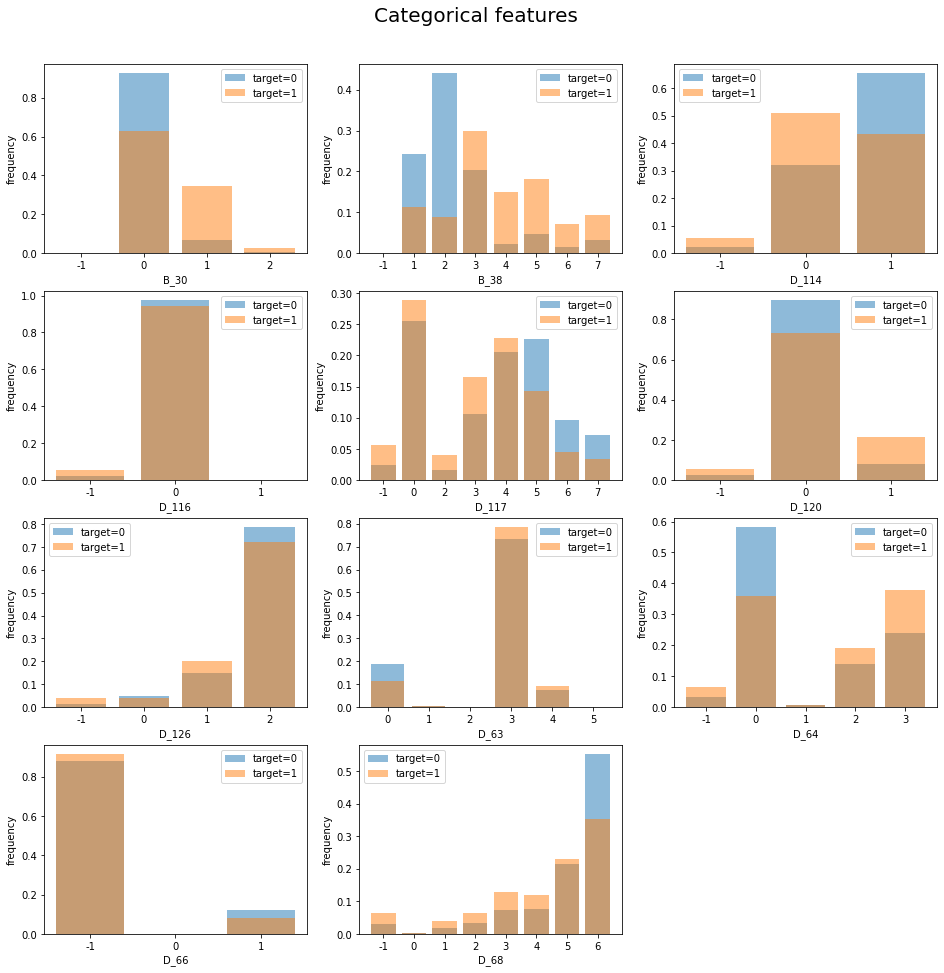

In [45]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',\
                'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
plt.figure(figsize=(16, 16))
for i, f in enumerate(cat_features):
    plt.subplot(4, 3, i+1)
    temp = train[f][train.target == 0].value_counts(dropna=False, normalize=True)
    temp = pd.DataFrame(temp.sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = train[f][train.target == 1].value_counts(dropna=False, normalize=True)
    temp = pd.DataFrame(temp.sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Categorical features', fontsize=20, y=0.93)
plt.show()
del temp

**Insight:**
- Every feature has at most eight categories (including a nan category). One-hot encodings are feasible.
- The distributions for target=0 and target=1 differ. This means that every feature gives some information about the target.


## The binary features

Two features are binary:
- B_31 is always 0 or 1.
- D_87 is always 1 or missing.

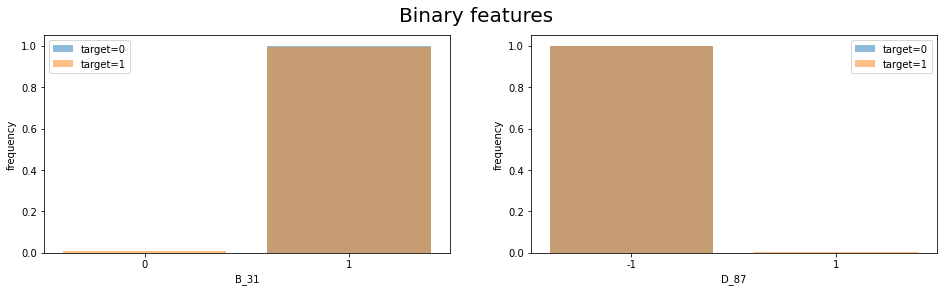

In [46]:
bin_features = ['B_31', 'D_87']
plt.figure(figsize=(16, 4))
for i, f in enumerate(bin_features):
    plt.subplot(1, 2, i+1)
    temp = train[f][train.target == 0].value_counts(dropna=False, normalize=True)
    temp = pd.DataFrame(temp.sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = train[f][train.target == 1].value_counts(dropna=False, normalize=True)
    temp = pd.DataFrame(temp.sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Binary features', fontsize=20)
plt.show()
del temp

**Insight:** If you impute missing values for D_87,
don't fall into the trap of imputing the mean - the feature would become useless...


## The numerical features

If we plot histograms of the 175 numerical features,
we see that they have all kinds of distributions:

175


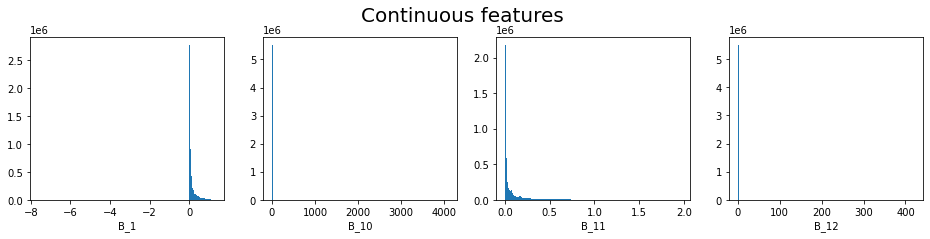

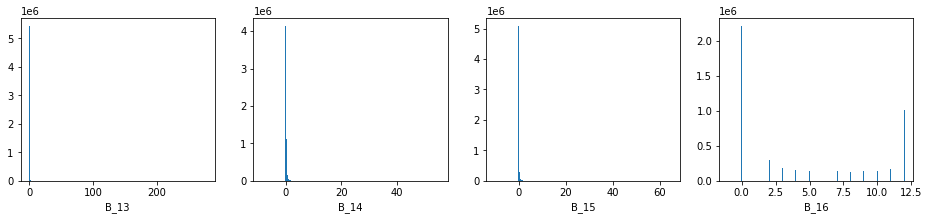

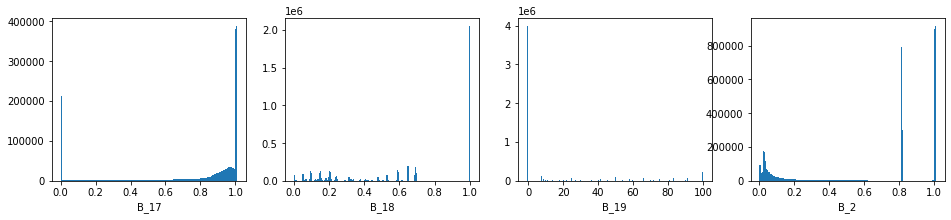

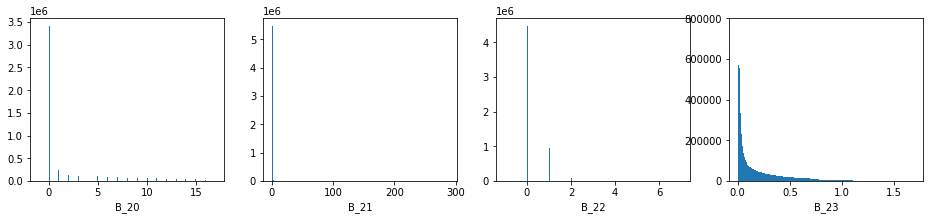

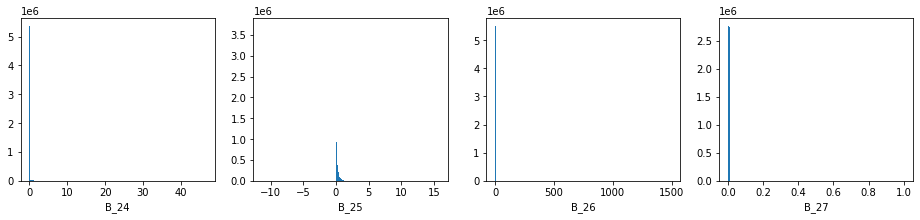

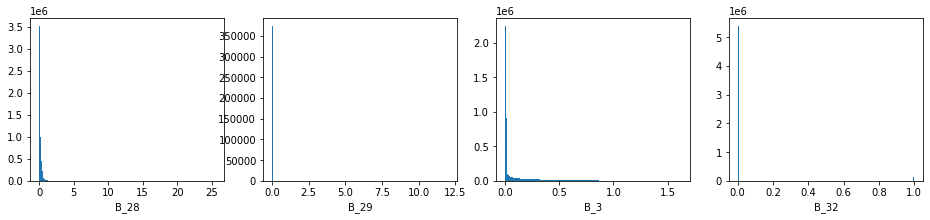

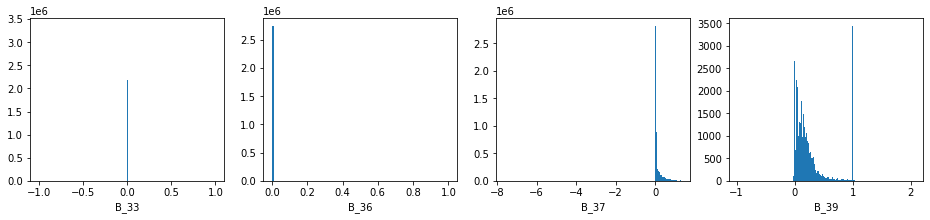

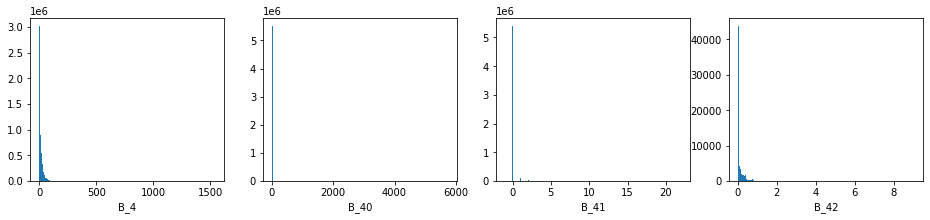

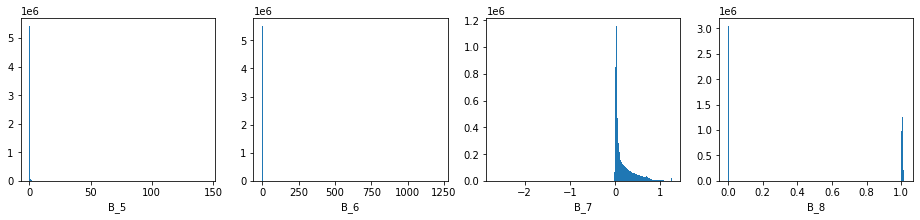

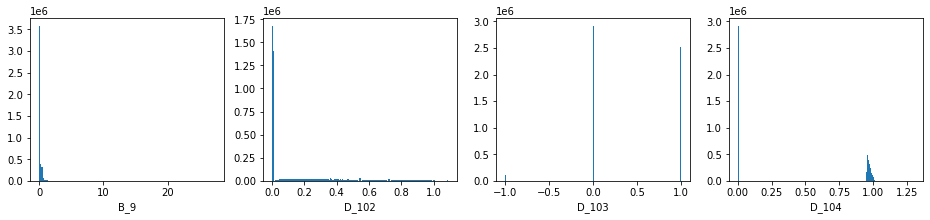

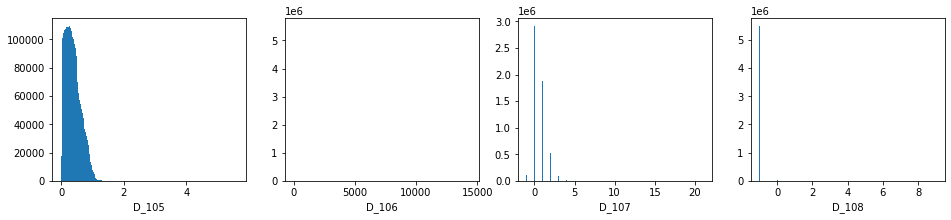

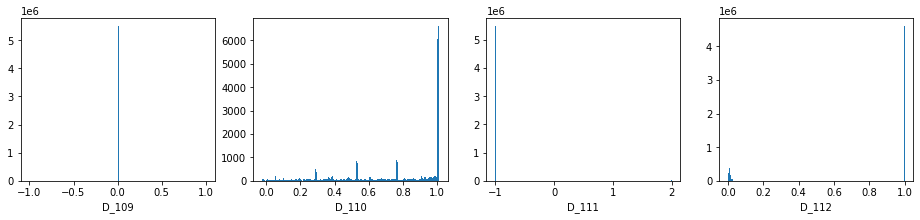

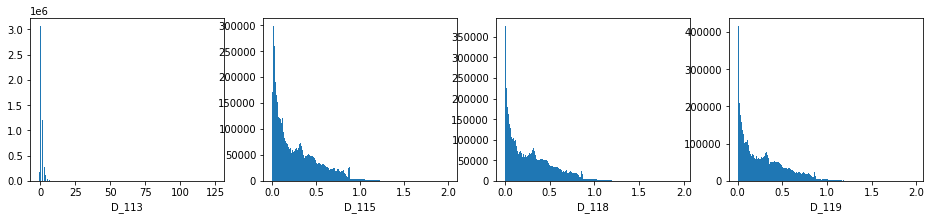

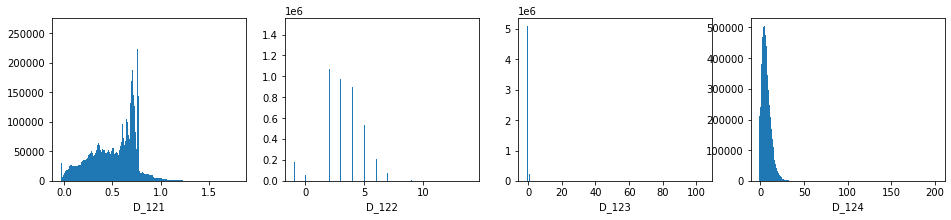

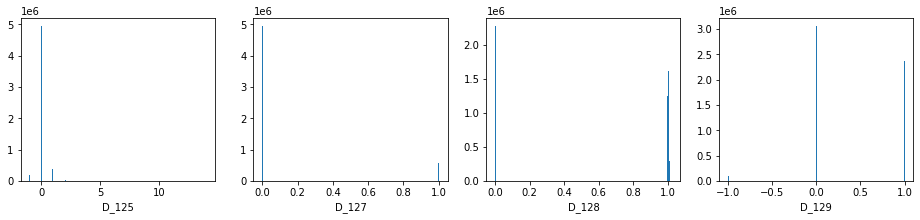

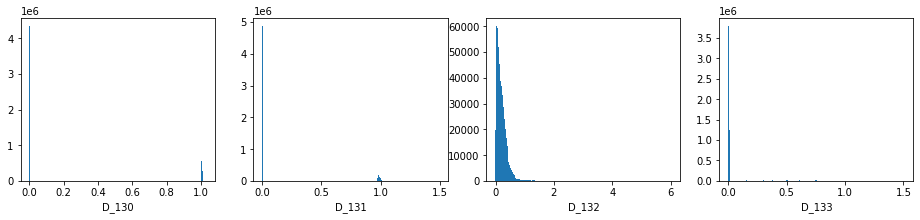

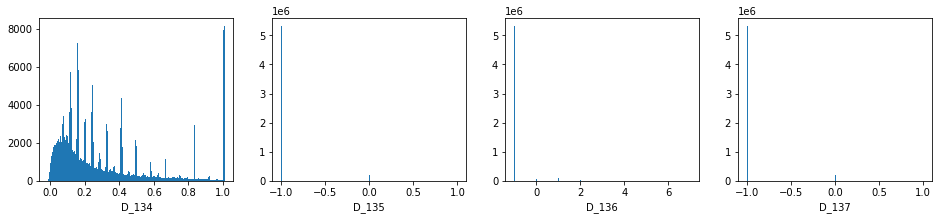

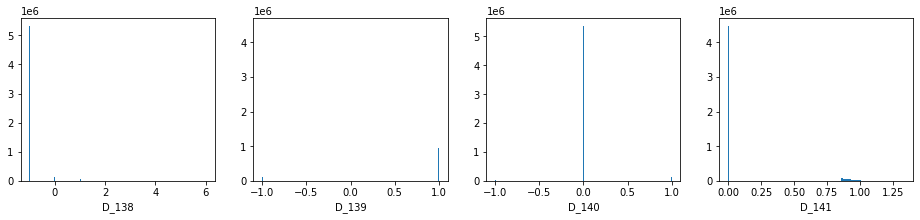

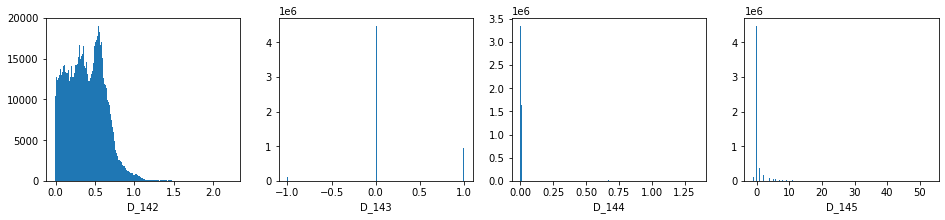

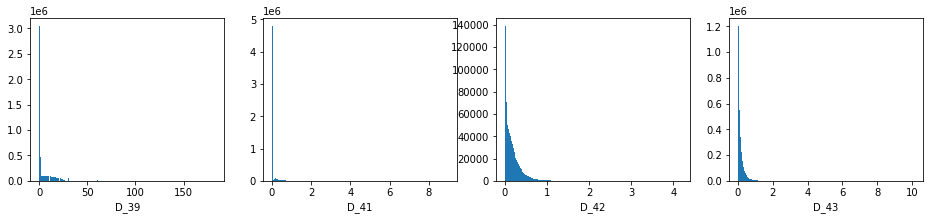

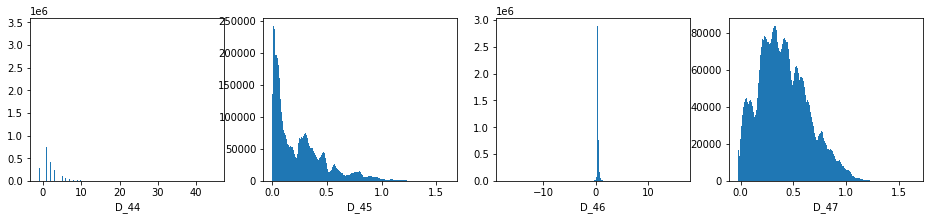

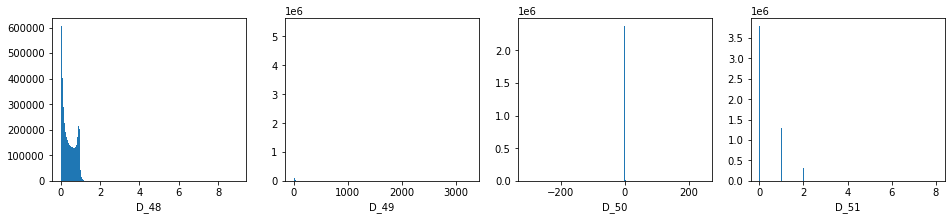

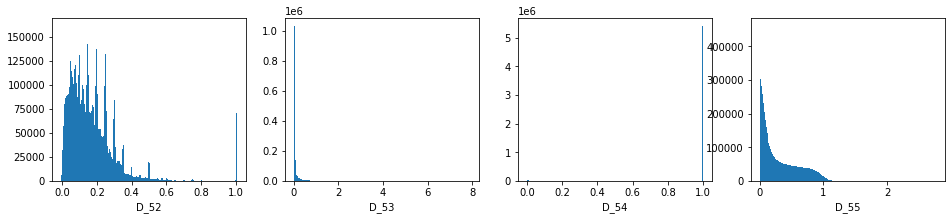

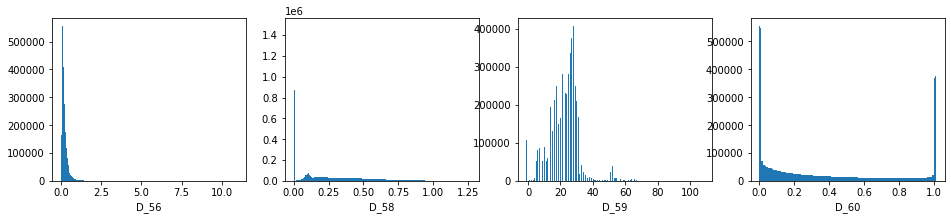

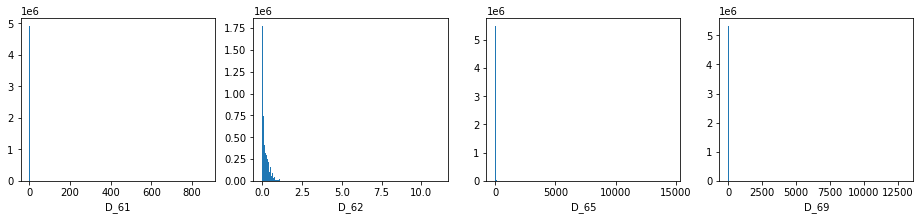

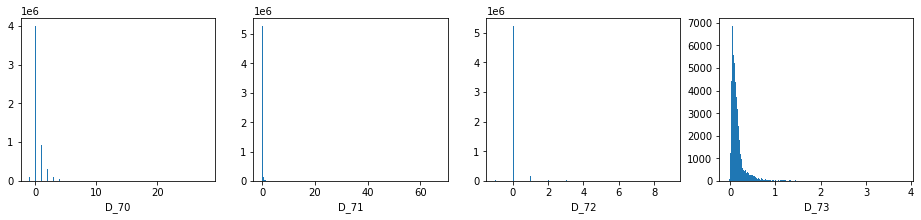

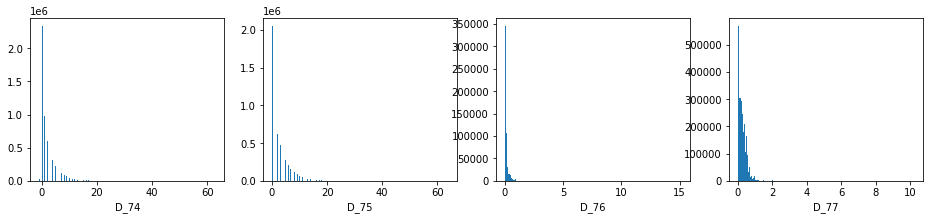

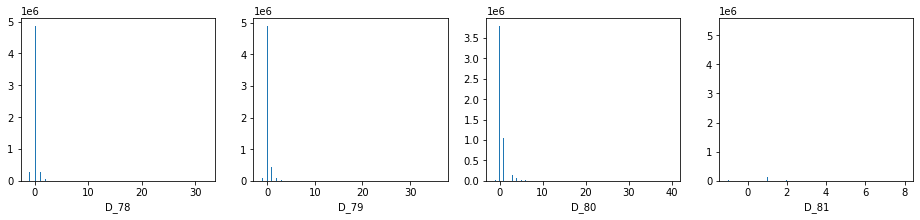

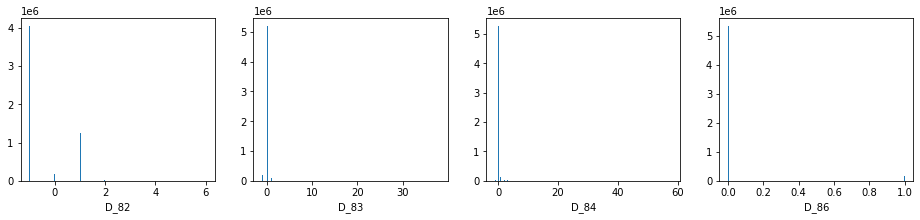

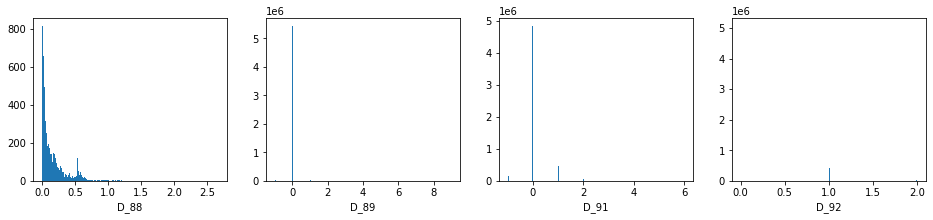

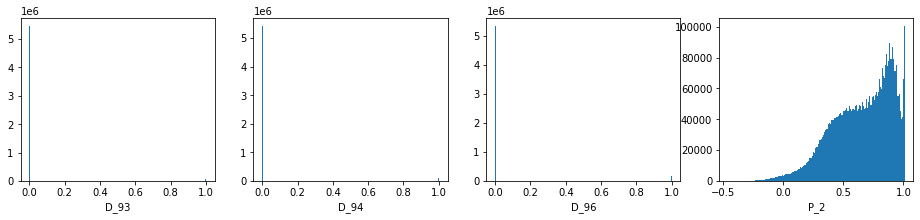

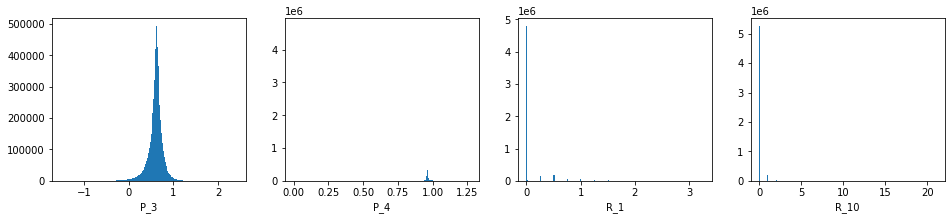

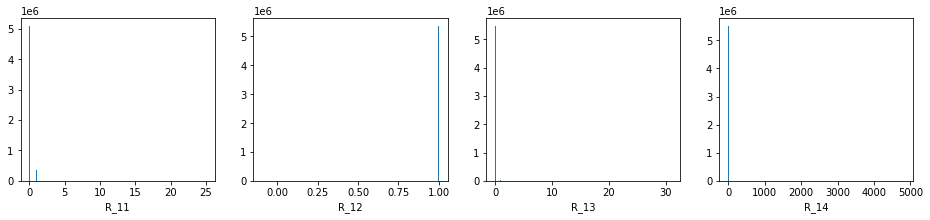

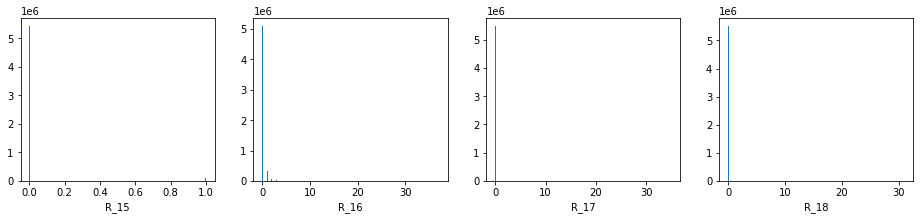

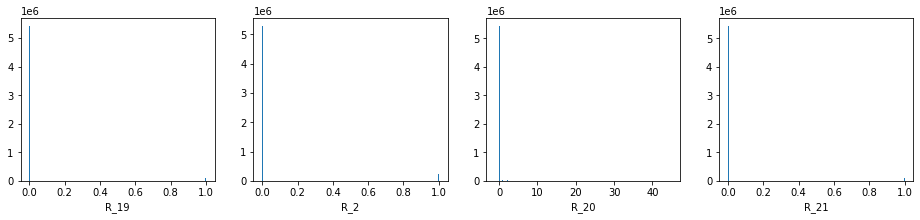

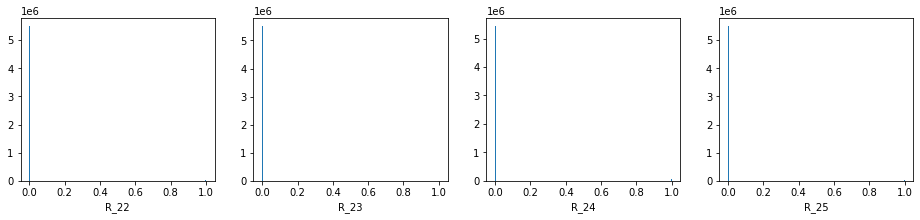

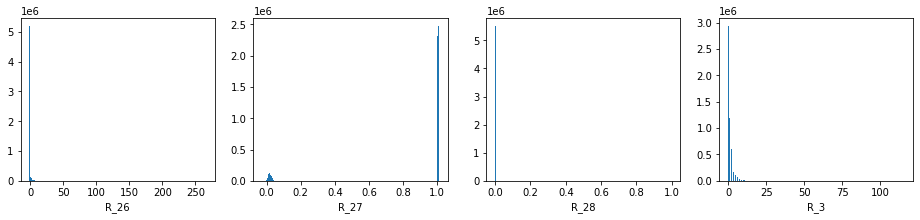

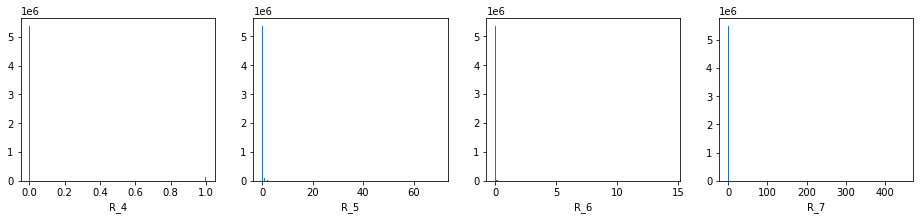

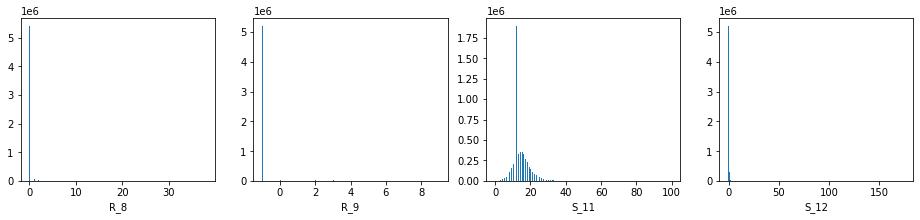

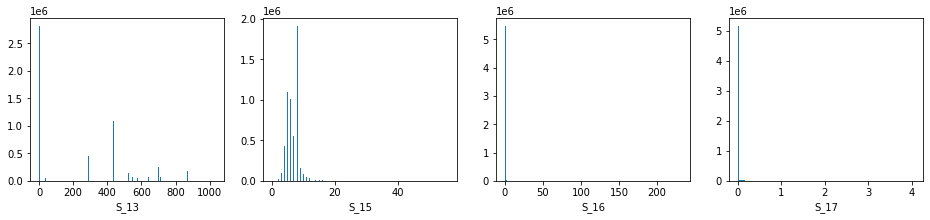

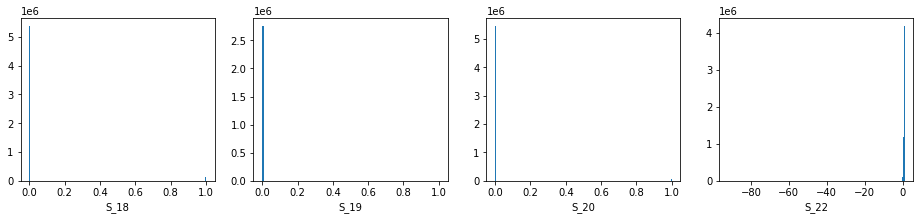

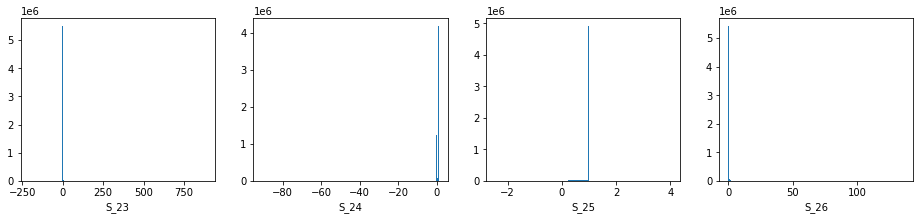

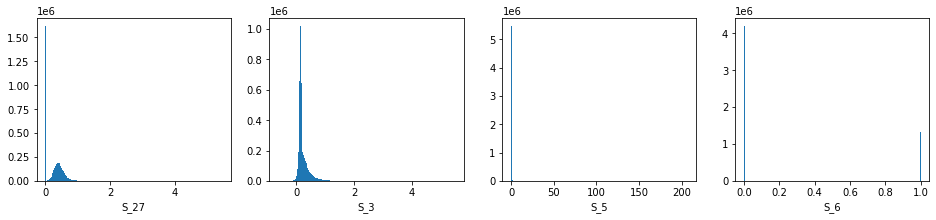

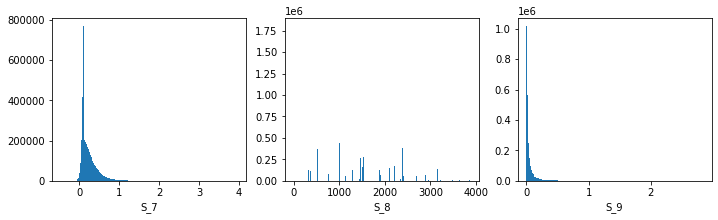

In [47]:
cont_features = sorted([f for f in train.columns 
                        if f not in cat_features + bin_features + ['customer_ID', 'target', 'S_2']])
print(len(cont_features))
# print(cont_features)
NCOLS = 4
for i, f in enumerate(cont_features):
    if i % NCOLS == 0:
        if i > 0:
            plt.show()
        plt.figure(figsize=(16, 3))
        if i == 0:
    plt.subplot(1, NCOLS, i % NCOLS + 1)
    plt.hist(train[f], bins=200)
    plt.xlabel(f)
plt.show()

**Insight:** Histograms with white space at the left or right end can indicate
that the data contain outliers. We will have to deal with these outliers.
But are these data really outliers? Maybe they are, but they could as well be
legitimate traces of rare events. We do not know...

In [ ]:
del train, test, train_labels